# Testing File
---
_This notebook is for testing new functionality before introducing it into the program._

### Protocol
---
_Pokémon Showdown is accessible via websockets, so I can interact with the website from this file (sending messages, logging in, and so on)._
_Found here: https://github.com/smogon/pokemon-showdown/blob/master/PROTOCOL.md_

_This has been done before in python here: https://github.com/pmariglia/showdown/blob/master/showdown/websocket_client.py_

**Variables I'll need**:
* Websocket UI
* Username and Password
* Format
* Team to use (if applicable)

In [31]:
import asyncio
import websockets
import requests
import json
import random

uri = "wss://sim3.psim.us/showdown/websocket"
loginuri = "https://play.pokemonshowdown.com/action.php"
testusername = "thisisatest12345"
testpassword = "password" # very secure :)

socket = await websockets.connect(uri)
print(socket)
challid = 0
challstr = ""
i = True


while(i):
    received = await socket.recv()
    print(received)

    messages = received.split("|")
    if(messages[1] == "challstr"):
        challid = messages[2]
        challstr= messages[3]
        i = False

challstr = "|".join([challid, challstr])
print(challstr)
print("A")


loggedIn = requests.post(
    loginuri,
    data={
        "act": "login",
        "name": testusername,
        "pass": testpassword,
        "challstr": challstr,
    }
)

# Finish logging in by grabbing the "assertion" given to us by showdown in JSON.
jsonOut = json.loads(loggedIn.text[1:])
message = ["/trn "+testusername+",0,"+jsonOut["assertion"]]
print(message)
message = "|"+"|".join(message)
print(message)
await socket.send(message)
received = await socket.recv()
print(received)

|updateuser|‽Guest 7305117|0|102|{"blockChallenges":false,"blockPMs":false,"ignoreTickets":false,"hideBattlesFromTrainerCard":false,"blockInvites":false,"doNotDisturb":false,"blockFriendRequests":false,"allowFriendNotifications":false,"displayBattlesToFriends":false,"hideLogins":false,"hiddenNextBattle":false,"inviteOnlyNextBattle":false,"language":null}
|formats|,1|S/V Singles|[Gen 9] Random Battle,f|[Gen 9] Unrated Random Battle,b|[Gen 9] Free-For-All Random Battle,7|[Gen 9] Random Battle (Blitz),f|[Gen 9] Multi Random Battle,5|[Gen 9] OU,e|[Gen 9] Ubers,e|[Gen 9] UU,e|[Gen 9] RU,e|[Gen 9] NU,e|[Gen 9] PU,e|[Gen 9] LC,e|[Gen 9] Monotype,e|[Gen 9] CAP,e|[Gen 9] BSS Reg G,5c|[Gen 9] BSS Reg H,5e|[Gen 9] Team Star Challenge,1e|[Gen 9] Custom Game,c|,1|S/V Doubles|[Gen 9] Random Doubles Battle,f|[Gen 9] Doubles OU,e|[Gen 9] Doubles Ubers,e|[Gen 9] Doubles UU,e|[Gen 9] Doubles LC,c|[Gen 9] VGC 2023 Reg D,5c|[Gen 9] VGC 2024 Reg G,5c|[Gen 9] VGC 2024 Reg H,5e|[Gen 9] VGC 2024 Reg H (Bo3),1

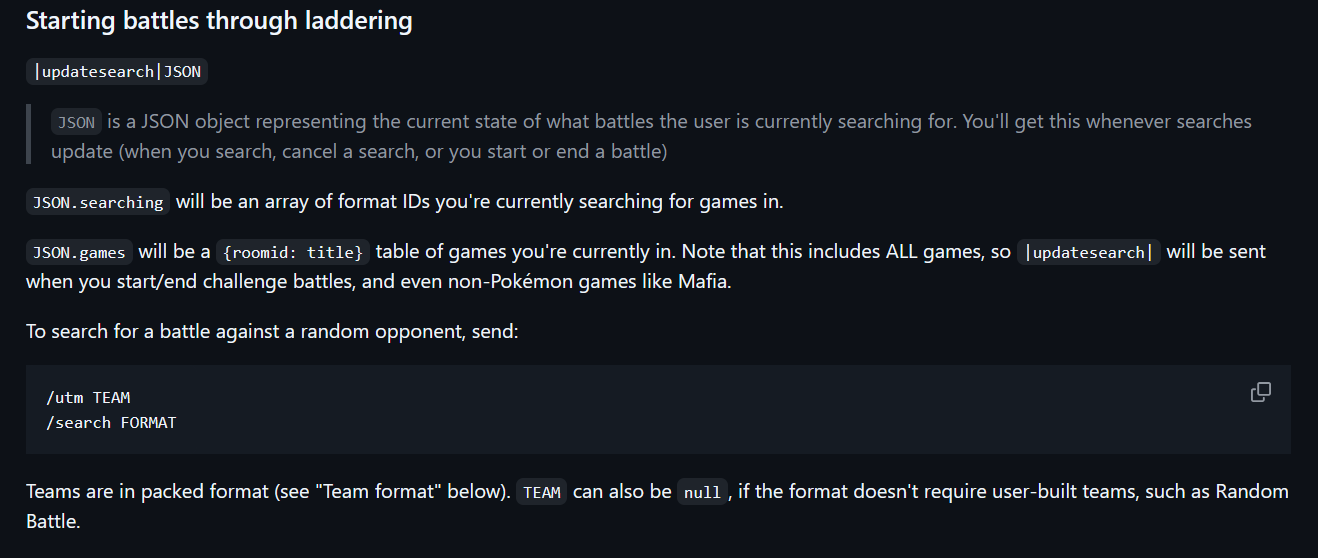

https://github.com/smogon/pokemon-showdown/blob/master/sim/SIM-PROTOCOL.md#sending-decisions
https://github.com/smogon/pokemon-showdown/blob/master/sim/SIM-PROTOCOL.md

In [ ]:
message = ["|/search gen9randombattle|"]
await socket.send(message)

# SUCCESFULLY STARTED A BATTLE
while True:
    msg = await socket.recv()
    msgs = msg.split("|")
    if 'battle' in msgs[0]:
        battle_tag = msgs[0][1:].strip()
        print(msg)
    if 'request' in msgs[1] and len(msgs[2]) > 9:

        requestOutput = json.loads(msgs[2])

        if "active" in requestOutput:
            randomMove = random.choice(requestOutput["active"][0]["moves"])["id"]
            print(randomMove)
            message = [battle_tag+'|/choose move '+randomMove+"|"+str(requestOutput["rqid"])]
            print(message)
            await socket.send(message)
        




>battle-gen9randombattle-2242592753
|init|battle
|title|nxndjdjjss vs. thisisatest12345
|j|☆nxndjdjjss
|j|‽thisisatest12345

>battle-gen9randombattle-2242592753
|request|
>battle-gen9randombattle-2242592753
|t:|1731441957
|gametype|singles
>battle-gen9randombattle-2242592753
|player|p1|nxndjdjjss|170|1000
>battle-gen9randombattle-2242592753
|request|{"active":[{"moves":[{"move":"Draining Kiss","id":"drainingkiss","pp":16,"maxpp":16,"target":"normal","disabled":false},{"move":"Nasty Plot","id":"nastyplot","pp":32,"maxpp":32,"target":"self","disabled":false},{"move":"Shadow Ball","id":"shadowball","pp":24,"maxpp":24,"target":"normal","disabled":false},{"move":"Will-O-Wisp","id":"willowisp","pp":24,"maxpp":24,"target":"normal","disabled":false}],"canTerastallize":"Fairy"}],"side":{"name":"thisisatest12345","id":"p2","pokemon":[{"ident":"p2: Spectrier","details":"Spectrier, L75","condition":"274/274","active":true,"stats":{"atk":102,"def":134,"spa":261,"spd":164,"spe":239},"moves":["draini

TypeError: can only concatenate str (not "int") to str